## VARIANT CALLING USING DEEP LEARNING


#### Importing libraries

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import intervaltree 
import random

1. *aln_tensor_fn* : This file contains information about sequence alignments at specific genomic positions in the form of a tensor.
2. *variant_set_fn* : This file contains information about genetic variants, specifying details such as the genomic position, reference allele, alternate allele, and possibly additional information like genotype (homozygous, heterozygous).
3. *mask_bed_fn* : This file contains the initial and end positions of masked regions. The "masked regions" often refer to regions of the genome that should be excluded or ignored during analysis. These regions might be masked for various reasons, such as having poor quality or containing repetitive elements that are difficult to align accurately.

In [3]:
def get_training_array( aln_tensor_fn, variant_set_fn, mask_bed_fn ):
    # Mapping of DNA bases to numerical values
    base2num = dict(zip("ACGT",(0, 1, 2, 3)))

    # Create an interval tree to store masked regions
    tree =  intervaltree.IntervalTree()
    with open(mask_bed_fn) as f:
        for row in f:
            row = row.strip().split()
            b = int(row[1])
            e = int(row[2])
            tree.addi(b, e, None)

    # Initialize a dictionary to store information about variant positions
    Y_intitial = {}
    with open( variant_set_fn ) as f:
        for row in f:
            row = row.strip().split()
            # Determine if the variant is heterozygous or not
            if row[3] == "0":
                het = True
            else:
                het = False
            
            pos = int(row[0])
            # Skip positions not present in the masked regions
            if len(tree.at(pos)) == 0:
                continue
            # Initialize a base vector
            base_vec = [0,0,0,0,0,0,0,0]  #first 4, base vec, last 4, het, hom, non-variant, not-SNPs
            # Update the base vector based on the variant type
            if het:
                base_vec[base2num[row[1][0]]] = 0.5
                base_vec[base2num[row[2][0]]] = 0.5
                base_vec[4] = 1.
            else:
                base_vec[base2num[row[2][0]]] = 1
                base_vec[5] = 1.

            if len(row[1]) > 1 or len(row[2]) > 1 :  # not simple SNP case
                base_vec[7] = 1.
                base_vec[4] = 0.
                base_vec[5] = 0.
        
            Y_intitial[pos] = base_vec
            
    Y_pos = sorted(Y_intitial.keys())
    cpos = Y_pos[0]
    for pos in Y_pos[1:]:
        if abs(pos - cpos) < 12:
            Y_intitial[pos][7] = 1
            Y_intitial[cpos][7] = 1
            
            Y_intitial[pos][4] = 0
            Y_intitial[cpos][4] = 0
            Y_intitial[pos][5] = 0
            Y_intitial[cpos][5] = 0
        cpos = pos
    
     # Initialize a dictionary to store information about the alignment tensor
    X_intitial = {}  

    with open( aln_tensor_fn ) as f:
        for row in f:
            row = row.strip().split()
            pos = int(row[0])
            # Skip positions not present in the masked regions
            if len(tree.at(pos)) == 0:
                continue
            ref_seq = row[1]
            # Skip positions with reference sequences containing unexpected characters
            if ref_seq[7] not in ["A","C","G","T"]:
                continue
            vec = np.reshape(np.array([float(x) for x in row[2:]]), (15,3,4))

            vec = np.transpose(vec, axes=(0,2,1))
            # Skip positions with low coverage
            if sum(vec[7,:,0]) < 5:
                continue
            
            vec[:,:,1] -= vec[:,:,0]#Subtract the values in the second dimension from the values in the first dimension
            vec[:,:,2] -= vec[:,:,0]#Subtract the values in the third dimension from the values in the first dimension

            
            X_intitial[pos] = vec
            
            if pos not in Y_intitial:
                base_vec = [0,0,0,0,0,0,0,0]
                base_vec[base2num[ref_seq[7]]] = 1
                base_vec[6] = 1.
                Y_intitial[pos] = base_vec
                
    all_pos = sorted(X_intitial.keys())
    random.shuffle(all_pos)
    
    # Create arrays for X, Y, and positions
    Xarray = []
    Yarray = []
    pos_array = []
    for pos in all_pos:
        Xarray.append(X_intitial[pos])
        Yarray.append(Y_intitial[pos])
        pos_array.append(pos)
    Xarray = np.array(Xarray)
    Yarray = np.array(Yarray)

    return Xarray, Yarray, pos_array

#### Loading the dataset

In [4]:
Xarray, Yarray, pos_array = get_training_array(r"E:\aln_tensor_chr21",
                         r"E:\variants_chr21",
                         r"E:\CHROM21_v.3.3.2_highconf_noinconsistent.bed" )

In [5]:
print("Shape of Xarray : ",Xarray.shape)
print("Shape of Yarray : " ,Yarray.shape)
print("Length of position array : ",len(pos_array))

Shape of Xarray :  (53537, 15, 4, 3)
Shape of Yarray :  (53537, 8)
Length of position array :  53537


In [7]:
print(Xarray[0].T)

[[[  0.  55.   0.  57.   0.   0.   0.   0.   0.  52.  57.  56.   0.   0.
    48.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
     0.]
  [ 56.   0.  53.   0.  50.  55.  56.  56.  56.   0.   0.   0.  52.   0.
     0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  55.
     0.]]

 [[  3.  -4.   1.  -3.   2.   1.   0.   2.   1.  -3.  -1.   0.   0.   1.
    -1.]
  [  0.   2.   0.   2.   0.   0.   1.  36.   6.   0.   0.   0.   0.   0.
     0.]
  [ -5.   2.  -1.   1.  -4.  -3.  -3. -38.  -7.   3.   0.   0.   0.   2.
     0.]
  [  2.   0.   0.   0.   2.   2.   2.   0.   0.   0.   1.   0.   0.  -3.
     1.]]

 [[  3.  -4.   1.  -3.   2.   1.   0.   2.   1.  -3.  -1.   0.   0.   1.
    -1.]
  [  0.   2.   0.   2.   0.   0.   1.  36.   6.   0.   0.   0.   0.   0.
     0.]
  [ -5.   2.  -1.   1.  -4.  -3.  -3. -38.  -7.   3.   0.   0.   0.   2.
     0.]
  [  2.   0.   0.   0.   2.   2.   2.   0.   0.   0.   1.   0.   0.  -3.
     1.]]]


In [8]:
print(Yarray[0])

[0. 1. 0. 0. 0. 1. 0. 0.]


The first 4 elements of the Yarray specifies the A,C,G,T and the remaining 4 elements represents "Homozygous","Hetro","Variant", and "Complex-variant"

In [9]:
# Splitting the Yarray

Yarray_C , Yarray_V = np.split(Yarray,2,axis=1)
print("Yarray Shape : ",Yarray.shape)
print("Yarray_C shape : ",Yarray_C.shape)
print("Yarray_V shpae : ",Yarray_V.shape)
print("\nPrinting elements in the array")
print("Yarray[0] : ",Yarray[0])
print("Yarray_C[0] : ",Yarray_C[0])
print("Yarray_V[0] : ",Yarray_V[0])

Yarray Shape :  (53537, 8)
Yarray_C shape :  (53537, 4)
Yarray_V shpae :  (53537, 4)

Printing elements in the array
Yarray[0] :  [0. 1. 0. 0. 0. 1. 0. 0.]
Yarray_C[0] :  [0. 1. 0. 0.]
Yarray_V[0] :  [0. 1. 0. 0.]


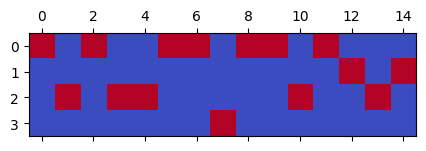

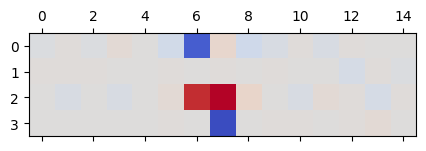

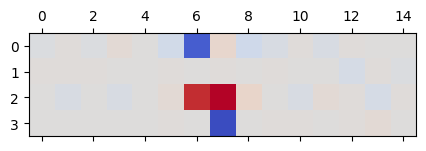

In [10]:
#plotting the array tensors
i = 200
plt.figure(figsize=(5, 2))
plt.matshow(Xarray[i,:,:,0].transpose(), vmin=0, vmax=50, cmap="coolwarm", fignum=0)
plt.figure(figsize=(5, 2))
plt.matshow(Xarray[i,:,:,1].transpose(), vmin=-50, vmax=50, cmap="coolwarm", fignum=0)
plt.figure(figsize=(5, 2))
plt.matshow(Xarray[i,:,:,2].transpose(), vmin=-50, vmax=50, cmap="coolwarm", fignum=0)

#### Creating the model 

In [29]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

In [58]:
inputs = Input(shape=(15,4,3))

conv1 = Conv2D(filters=64, kernel_size=(2,2),padding="same",activation="elu")(inputs)
pool1 = MaxPooling2D(pool_size=(4,1),strides=1)(conv1)

conv2 = Conv2D(filters=56, kernel_size=(3,2),padding="same",activation="elu")(pool1)
pool2 = MaxPooling2D(pool_size=(3,1),strides=1)(conv2)

flatten = Flatten()(pool2)

dense1 = Dense(128,activation="elu")(flatten)
drop1 = Dropout(0.40)(dense1)

dense2 = Dense(64,activation="elu")(drop1)
drop2 = Dropout(0.40)(dense2)

dense3 = Dense(32,activation="elu")(drop2)
drop3 = Dropout(0.50)(dense3)

dense4 = Dense(16,activation="elu")(drop3)
drop4 = Dropout(0.50)(dense4)

output1 = Dense(4,activation = "softmax",name="output1")(drop4)
output2 = Dense(4,activation = "elu",name="output2")(drop4)

In [59]:
model = Model(inputs=inputs, outputs=[output1, output2])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 15, 4, 3)]           0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 15, 4, 64)            832       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 12, 4, 64)            0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 12, 4, 56)            21560     ['max_pooling2d_8[0][0]'

In [60]:
model.compile(optimizer=tf._optimizers.Adam(learning_rate=0.0001),loss="mean_squared_error",metrics=['accuracy'])

#### Splitting the data for training and validation

In [61]:
from sklearn.model_selection import  train_test_split

x_train,x_val,y_train,y_val = train_test_split(Xarray,Yarray,train_size=0.8,random_state=10)

In [62]:
Ytrain_C , Ytrain_V = np.split(y_train,2,axis=1)
Yval_C, Yval_V = np.split(y_val,2,axis=1)

#### Training the model 

In [63]:
history = model.fit(x_train,{"output1":Ytrain_C,"output2":Ytrain_V},epochs=20,validation_data=(x_val,{"output1":Yval_C,"output2":Yval_V}))

Epoch 1/20
1339/1339 [==============================] - 36s 25ms/step - loss: 2.2746 - output1_loss: 0.1945 - output2_loss: 2.0800 - output1_accuracy: 0.2574 - output2_accuracy: 0.2488 - val_loss: 0.7107 - val_output1_loss: 0.1360 - val_output2_loss: 0.5748 - val_output1_accuracy: 0.1925 - val_output2_accuracy: 0.4508
Epoch 2/20
1339/1339 [==============================] - 35s 26ms/step - loss: 0.9890 - output1_loss: 0.1620 - output2_loss: 0.8270 - output1_accuracy: 0.2536 - output2_accuracy: 0.2951 - val_loss: 0.5713 - val_output1_loss: 0.1268 - val_output2_loss: 0.4444 - val_output1_accuracy: 0.3089 - val_output2_accuracy: 0.4506
Epoch 3/20
1339/1339 [==============================] - 35s 26ms/step - loss: 0.7622 - output1_loss: 0.1447 - output2_loss: 0.6175 - output1_accuracy: 0.2623 - output2_accuracy: 0.3157 - val_loss: 0.4479 - val_output1_loss: 0.1238 - val_output2_loss: 0.3241 - val_output1_accuracy: 0.2177 - val_output2_accuracy: 0.4566
Epoch 4/20
1339/1339 [==================

In [64]:
import pandas as pd 

history_df = pd.DataFrame(history.history)
history_df

,loss,output1_loss,output2_loss,output1_accuracy,output2_accuracy,val_loss,val_output1_loss,val_output2_loss,val_output1_accuracy,val_output2_accuracy
0,2.274564,0.194523,2.080041,0.257442,0.248803,0.710718,0.135955,0.574763,0.192473,0.450784
1,0.988966,0.162009,0.826956,0.253637,0.295127,0.571282,0.126842,0.444440,0.308928,0.450598
2,0.762199,0.144705,0.617495,0.262252,0.315721,0.447854,0.123787,0.324068,0.217688,0.456575
3,0.596152,0.134888,0.461265,0.266782,0.343576,0.351343,0.123627,0.227716,0.200504,0.620844
4,0.466109,0.129354,0.336755,0.277219,0.378062,0.297838,0.123501,0.174337,0.264942,0.647273
5,0.375834,0.126236,0.249598,0.284013,0.437484,0.262156,0.123177,0.138978,0.301083,0.696489
6,0.314626,0.124807,0.189819,0.289570,0.538187,0.227445,0.120872,0.106573,0.371498,0.751961
7,0.276478,0.122546,0.153932,0.310350,0.637185,0.207307,0.118130,0.089178,0.442753,0.788476
8,0.242440,0.116146,0.126294,0.343272,0.717014,0.167554,0.098394,0.069160,0.518958,0.856462
9,0.206415,0.097786,0.108629,0.419646,0.762661,0.132942,0.068790,0.064152,0.512607,0.868136


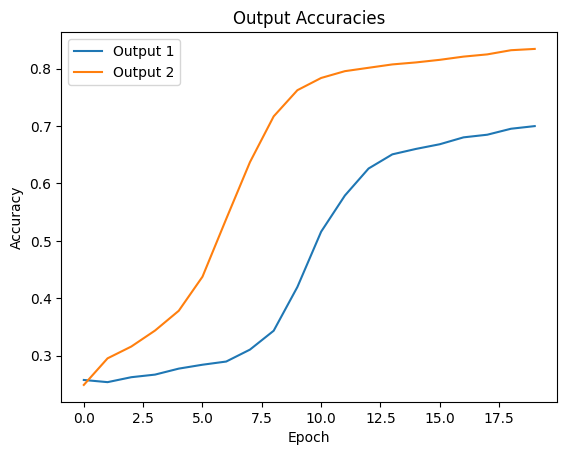

In [65]:
import matplotlib.pyplot as plt

plt.plot(history_df['output1_accuracy'], label='Output 1')
plt.plot(history_df['output2_accuracy'], label='Output 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Output Accuracies')
plt.legend()
plt.show()


In [66]:
model.save("Best_model_for_varient_calling.h5")

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Model Evaluation

In [67]:
Xarray2, Yarray2, pos_array2 = get_training_array(r"E:\aln_tensor_chr22", 
                         r"E:\variants_chr22", 
                        r"E:\CHROM22_v.3.3.2_highconf_noinconsistent.bed" )

In [68]:
print(Xarray2.shape)
print(Yarray2.shape)

(47234, 15, 4, 3)
(47234, 8)


In [69]:
Yarray2_C, Yarray2_V = np.split(Yarray2,2,axis=1)

In [70]:
base,t = model.predict(Xarray2)

1477/1477 [==============================] - 8s 5ms/step


In [71]:
base_m = base.argmax(axis=1)
t_m = t.argmax(axis=1)

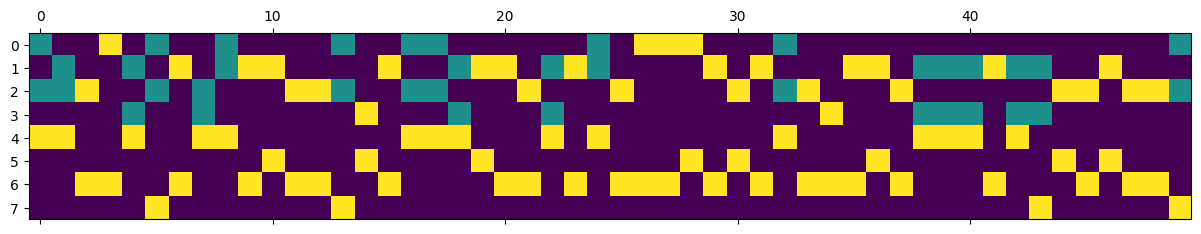

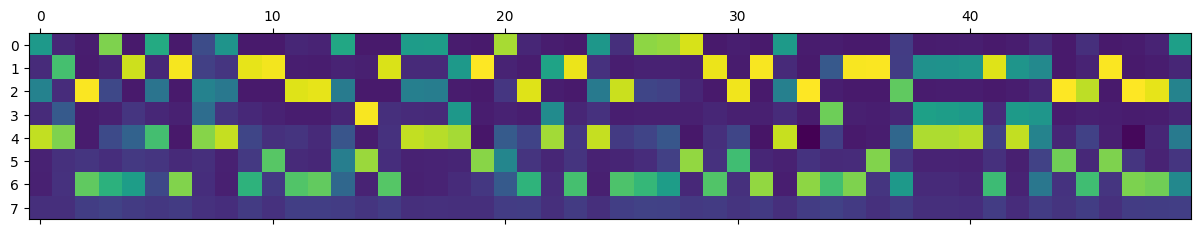

In [72]:
# # we can compare the output of the expected calls and the predicted calls

plt.figure(figsize=(15, 10))
plt.matshow(Yarray2[100:150,:].transpose(), fignum=0)
plt.figure(figsize=(15, 10))
plt.matshow(np.concatenate( (base[100:150,:],t[100:150,:]),1).transpose(), fignum=0)


In [73]:
from sklearn.metrics import classification_report

print(classification_report(Yarray2_V.argmax(axis=1), t.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     21809
           1       0.92      0.99      0.95      9691
           2       0.86      0.98      0.92     12609
           3       0.00      0.00      0.00      3125

    accuracy                           0.91     47234
   macro avg       0.68      0.73      0.71     47234
weighted avg       0.85      0.91      0.88     47234



C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo